In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sqlalchemy import desc

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, func
from sqlalchemy import cast
from sqlalchemy import text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#got attribute error in the next cell when using the names of the csv files. So adding the step to check available tables in the db.
available_tables = engine.table_names()
print(available_tables)

['measurement', 'station']


/var/folders/h6/rstm4b2j0g928d95j1p6tr400000gn/T/ipykernel_75168/3756458363.py:4: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  available_tables = engine.table_names()


In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)
# reflect the tables
measurement = Base.classes.measurement
station = Base.classes.station

In [6]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(classes)

['measurement', 'station']


In [7]:
# Save references to each table
tables = {}
for class_name in Base.classes.keys():
    table_reference = getattr(Base.classes, class_name)
    tables[measurement] = table_reference
    tables[station] = table_reference


In [8]:
# Create our session (link) from Python to the DB

Session = sessionmaker(bind=engine)
session = Session()
print(Base.metadata.bind)
print(session.bind)

None
Engine(sqlite:///Resources/hawaii.sqlite)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
#Date information is in the measurement table.

most_recent_date = session.execute("SELECT MAX(date) FROM measurement").fetchone()
print(f"The most recent date is: {most_recent_date[0]}")


The most recent date is: 2017-08-23


In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_data = session.query(measurement.prcp).filter(measurement.date == most_recent_date[0]).all()
print(f"The most recent precipitations are: {most_recent_data}")

# Calculate the date one year from the last date in data set.

one_year_before_date = session.query(
    func.date(func.max(measurement.date), '-365 days')
).scalar()

print(f"One year before the most recent date is: {one_year_before_date}")
# Perform a query to retrieve the data and precipitation data

query = session.query(measurement.date, measurement.prcp).\
    filter(text("date >= (SELECT date(MAX(date), '-365 day') FROM measurement)")).\
    order_by(measurement.date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql_query(query.statement, session.bind)
df.columns = ['date', 'prcp']

# Sort the dataframe by date
df = df.sort_values(by='date')

df.head(5)


The most recent precipitations are: [(0.0,), (0.0,), (0.08,), (0.45,)]
One year before the most recent date is: 2016-08-23


,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [16]:
# Filter out null values from lists
prcp_past12m = []
for prcp in prcp_past12m:
    if type(df.prcp) == int:
        prcp_past12m.append(df.prcp)
 

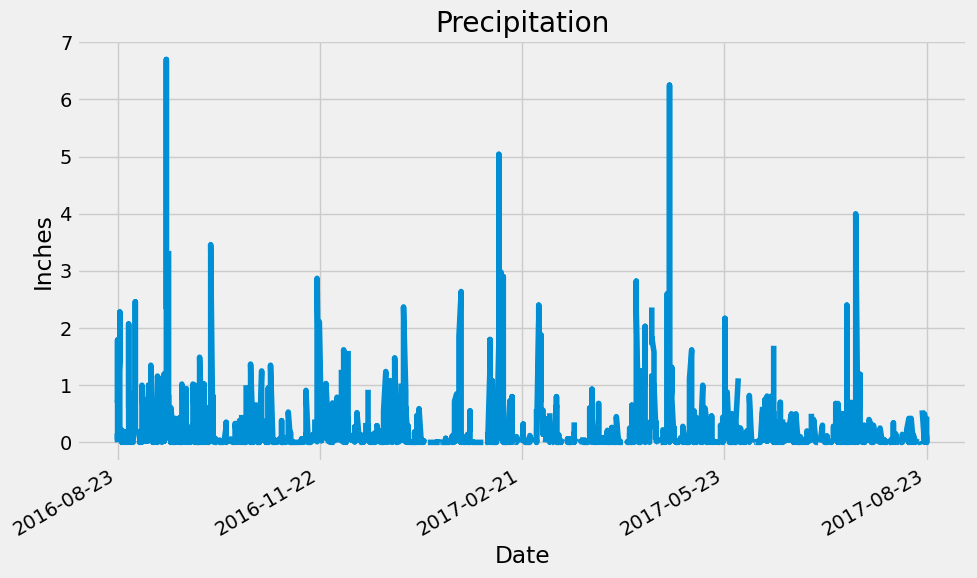

In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Apply the 'fivethirtyeight' style
plt.style.use('fivethirtyeight')

df['prcp'].plot(figsize=(10, 6))  
plt.title('Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')

# Set the x-axis to have only 5 dates
start_date = df.index.min()
end_date = df.index.max()
delta = (end_date - start_date) / 4  # To get 5 points
dates = [start_date + i * delta for i in range(5)]

plt.xticks(dates, [date.strftime('%Y-%m-%d') for date in dates])

# Rotate date labels to prevent overlap

plt.tight_layout()

plt.show()

In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = df.describe(include = 'all')
print(summary)


              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station).count()
station_count

9

In [38]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
USC00519281_info = session.query(measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()

USC00519281_info

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

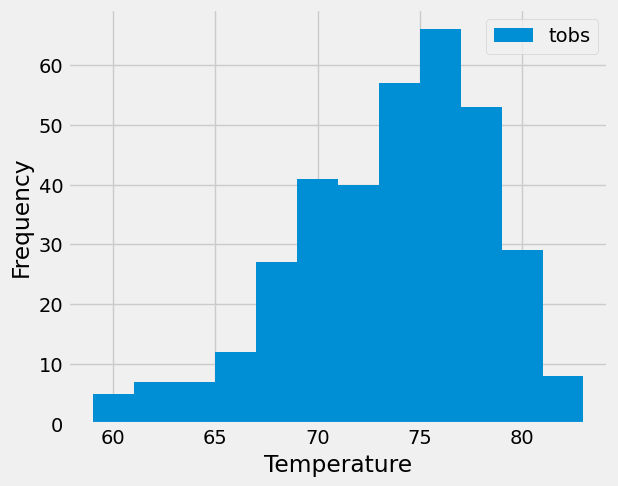

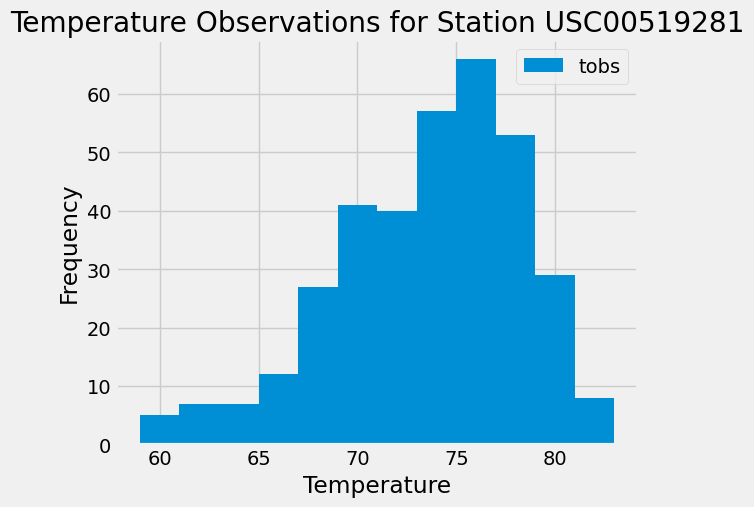

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(text("date >= (SELECT date(MAX(date), '-365 day') FROM measurement)")).\
    order_by(measurement.date).all()

df = pd.DataFrame(USC00519281_data, columns=['date', 'tobs'])

# Plot the results as a histogram
plt.figure(figsize=(6, 5))
df['tobs'].plot(kind='hist', bins=12, title='Temperature Observations for Station USC00519281',label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Close Session

In [52]:
# Close Session
session.close()